# Reinforcement Learning - Practical Session 1


## Review

A Markov Decision Process (MDP) is defined as tuple $(S, A, P, r, \gamma)$ where:
* $S$ is the state space
* $A$ is the action space 
* $P$ represents the transition probabilities, $P(s,a,s')$ is the probability of arriving at state $s'$ by taking action $a$ in state $s$
* $r$ is the reward function such that $r(s,a,s')$ is the reward obtained by taking action $a$ in state $s$ and arriving at $s'$
* $\gamma$ is the discount factor

A deterministic policy $\pi$ is a mapping from $S$ to $A$: $\pi(s)$ is the action to be taken at state $s$.

The goal of an agent is to find the policy $\pi$ that maximizes the expected sum of discounted rewards by following $\pi$. The value of $\pi$ is defined as

$$
V_\pi(s) = E\left[ \sum_{t=0}^\infty \gamma^t r(S_t, A_t, S_{t+1}) | S_0 = s \right]
$$

$V_\pi(s)$ and the optimal value function, defined as $V^*(s) = \max_\pi V_\pi(s)$, can be shown to satisfy the Bellman equations:

$$
V_\pi(s) = \sum_{s' \in S}  P(s,\pi(s),s')[r(s,\pi(s),s') + \gamma V_\pi(s')]
$$


$$
V^*(s) = \max_{a\in A} \sum_{s' \in S}  P(s,a,s')[r(s,a,s') + \gamma V^*(s')]
$$

It is sometimes better to work with Q functions:

$$
Q_\pi(s, a) = \sum_{s' \in S}  P(s,a,s')[r(s,a,s') + \gamma  Q^*(s', \pi(s')]
$$


$$
Q^*(s, a) = \sum_{s' \in S}  P(s,a,s')[r(s,a,s') + \gamma \max_{a'} Q^*(s', a')]
$$

such that $V_\pi(s) = Q_\pi(s, \pi(s))$ and $V^*(s) = \max_a Q^*(s, a)$.


### Using value iteration to compute an optimal policy
If the reward function and the transition probabilities are known (and the state and action spaces are not very large), we can use dynamic programming methods to compute $V^*(s)$. Value iteration is one way to do that.


#####  Value iteration to compute $V^*(s)$
$$
T^* Q(s,a) = \sum_{s'}P(s'|s,a)[ r(s, a, s') + \gamma \max_{a'} Q(s', a')]   \\
$$


* For any $Q_0$, let $Q_n = T^* Q_{n-1}$. 
* We have $\lim_{n\to\infty}Q_n = Q^*$ and $Q^* = T^* Q^*$


##### Finding the optimal policy from $V^\pi(s)$

The optimal policy $\pi^*$ can be computed as

$$
\pi^*(s) \in \arg\max_{a\in A} Q^*(s, a) =  \arg\max_{a\in A} \sum_{s' \in S}  P(s,a,s')[r(s,a,s') + \gamma V^*(s')]
$$

###  Q-Learning and SARSA 

When the reward function and the transition probabilities are *unknown*, we cannot use dynamic programming to find the optimal value function. Q-Learning and SARSA are stochastic approximation algorithms that allows us to estimate the value function by using only samples from the environment.

#####  Q-learning

The Q-Learning algorithm allows us to estimate the optimal Q function using only trajectories from the MDP obtained by following some exploration policy. 

Q-learning with $\varepsilon$-greedy exploration does the following update at time $t$:

1. In state $s_t$, take action $a_t$  such that $a_t$ is random with probability $\varepsilon$ and $a_t \in \arg\max_a \hat{Q}_t(s_t,a) $ with probability $1-\varepsilon$;
2. Observe $s_{t+1}$ and reward $r_t$;
3. Compute $\delta_t = r_t + \gamma \max_a \hat{Q}_t(s_{t+1}, a) - \hat{Q}_t(s_t, a_t)$;
4. Update $\hat{Q}_{t+1}(s, a) = \hat{Q}_t(s, a) + \alpha_t(s,a)\delta_t\mathbb{1}\{s=s_t, a=a_t\}  $


##### SARSA

SARSA is similar to Q-learning, but it is an *on-policy* algorithm: it follows a (stochastic) policy $\pi_Q$ and updates its estimate towards the value of this policy. One possible choice is:

$$
\pi_Q(a|s) = \frac{ \exp(\tau^{-1}Q(s,a))  }{\sum_{a'}\exp(\tau^{-1}Q(s,a')) }
$$
where $\tau$ is a "temperature" parameter: when $\tau$ approaches 0, $\pi_Q(a|s)$ approaches the greedy (deterministic) policy $a \in \arg\max_{a'}Q(s,a')$.

At each time $t$, SARSA keeps an estimate $\hat{Q}_t$ of the true Q function and uses $\pi_{\hat{Q}_t}(a|s)$ to choose the action $a_t$. If $\tau \to 0$ with a proper rate as $t \to \infty$, $\hat{Q}_t$ converges to $Q$ and $\pi_{\hat{Q}_t}(a|s)$ converges to the optimal policy $\pi^*$. 

The SARSA update at time $t$ is done as follows:

1. In state $s_t$, take action $a_t \sim \pi_{\hat{Q}_t}(a|s_t)$ ;
2. Observe $s_{t+1}$ and reward $r_t$;
3. Sample the next action $a_{t+1} \sim \pi_{\hat{Q}_t}(a|s_{t+1})$;
4. Compute $\delta_t = r_t + \gamma \hat{Q}_t(s_{t+1}, a_{t+1}) - \hat{Q}_t(s_t, a_t)$
5. Update $\hat{Q}_{t+1}(s, a) = \hat{Q}_t(s, a) + \alpha_t(s,a)\delta_t\mathbb{1}\{s=s_t, a=a_t\}$

## Goals

Your goal is to implement Value Iteration, Q-Learning and SARSA for the [Frozen Lake](https://gym.openai.com/envs/FrozenLake-v0/) environment.

* In exercise 1, you will implement the Bellman operators $T^\pi$ and $T^*$ and verify their properties.
* In exercise 2, you will implement value iteration
* In exercises 3 and 4, you will implement Q-Learning and SARSA


In [1]:
import numpy as np
from scipy.special import softmax # for SARSA
import matplotlib.pyplot as plt
from frozen_lake import FrozenLake
from test_env import ToyEnv1

ModuleNotFoundError: No module named 'test_env'

# FrozenLake environment

In [2]:
# Creating an instance of FrozenLake
# --- If deterministic=False, transitions are stochastic. Try both cases!
env = FrozenLake(gamma=0.95, deterministic=False) 
# Small environment for debugging
# env = ToyEnv1(gamma=0.95)

# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s, a, s'] = env.P[s, a, s']
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=1, a=3,s'=2): ", env.reward_func(1,3,2))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward)
    if done:
        break
    state = next_state
print("")

# Visualizing the environment
try:
    env.render()
except:
    pass # render not available

Set of states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Set of actions: [0, 1, 2, 3]
Number of states:  16
Number of actions:  4
P has shape:  (16, 4, 16)
discount factor:  0.95

initial state:  0
reward at (s=1, a=3,s'=2):  0.0

random policy =  [0 0 1 0 1 1 0 2 2 1 2 2 1 3 1 1]
(s, a, s', r):
0 0 0 0.0
0 0 4 0.0
4 1 8 0.0
8 2 9 0.0

(S: starting point, safe) (F: frozen surface, safe) (H: hole, fall to your doom) (G: goal, where the frisbee is located)
SFFF
FHFH
FFFH
HFFG
Current state 9


# Exercise 1: Bellman operator

1. Write a function that takes an environment and a state-action value function $Q$ as input and returns the Bellman optimality operator applied to $Q$, $T^* Q$ and the greedy policy with respect to $Q$.
3. Let $Q_1$ and $Q_2$ be state-action value functions. Verify the contraction property:  $\Vert T^* Q_1 - T^* Q_2\Vert \leq \gamma ||Q_1 - Q_2||$, where $||V|| = \max_{s,a} |Q(s,a)|$.

In [3]:
# --------------
# Solution to 1.
# --------------
def bellman_operator(Q, env):
    TQ = np.zeros((env.Ns, env.Na))
    greedy_policy = np.zeros(env.Ns)
    for s in env.states:
        for a in env.actions:
            prob = env.P[s, a, :]
            rewards = np.array([float(env.reward_func(s,a, s_)) for s_ in env.states])
            TQ[s,a] = np.sum( prob*(rewards + env.gamma*Q.max(axis=1))  )

    argmax = np.argmax(TQ, axis = 1)
    greedy_policy = argmax
    
    return TQ, greedy_policy

In [4]:
# --------------
# Solution to 2.
# --------------
n_simulations = 15

print("Contraction of Bellman operator: ")
for ii in range(n_simulations):
    Q1 = np.random.randn(env.Ns, env.Na)
    Q2 = np.random.randn(env.Ns, env.Na)

    # Contraction of Bellman operator
    contraction = np.abs(bellman_operator(Q1, env)[0] - bellman_operator(Q2, env)[0]).max() / np.abs(Q1-Q2).max()
    print(contraction)
    assert contraction <= env.gamma + 1e-12 

Contraction of Bellman operator: 
0.4705311455663862
0.5018592496431588
0.5212830535495661
0.3741195746613664
0.4245633315232942
0.46726741407590683
0.45440986862852795
0.5346380124717157
0.4707176218584958
0.31085018712299795
0.507503872009211
0.36163134057140556
0.4700491406450985
0.3259317884415954
0.3893022279254102


# Exercise 2: Value iteration

1. (Optimal Value function) Write a function that takes as input an initial state-action value function `Q0` and an environment `env` and returns a vector `Q` such that $||T^* Q -  Q ||_\infty \leq \varepsilon $ and the greedy policy with respect to $Q$.
2. Test the convergence of the function you implemented.

In [5]:
# --------------
# Solution to 1.
# --------------
def value_iteration(Q0, env, epsilon=1e-5):
    """
    Finding the optimal value function. To be done!
    """
    it = 1
    Q = Q0
    while True:
        TQ, greedy_policy = bellman_operator(Q, env)

        err = np.abs(TQ-Q).max() 
        if err < epsilon:
            return TQ, greedy_policy

        Q = TQ
        it += 1

In [6]:
# --------------
# Solution to 2.
# --------------
epsilon = 1e-6
Q0 = np.zeros((env.Ns, env.Na))

Q, greedy_policy = value_iteration(Q0, env, epsilon)
err = np.abs(Q - bellman_operator(Q, env)[0]).max()
print("norm of T(Q) - Q = ", err)
assert err <= epsilon

env.reset()
print(env.render())
env.step(1)
env.step(1)
env.step(2)
env.step(1)
env.step(2)
env.step(2)
print(env.render())
print(greedy_policy)

norm of T(Q) - Q =  9.185378004872291e-07
(S: starting point, safe) (F: frozen surface, safe) (H: hole, fall to your doom) (G: goal, where the frisbee is located)
SFFF
FHFH
FFFH
HFFG
Current state 0
None
(S: starting point, safe) (F: frozen surface, safe) (H: hole, fall to your doom) (G: goal, where the frisbee is located)
SFFF
FHFH
FFFH
HFFG
Current state 5
None
[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]


# Exercise 3: Q-Learning

Implement Q-learning and test its convergence.

In [7]:
#-------------------------------
# Q-Learning implementation
# ------------------------------

class QLearning:
    """
    Implements Q-learning algorithm with epsilon-greedy exploration

    If learning_rate is None; alpha(x,a) = 1/max(1, N(s,a))**alpha
    """
    def __init__(self, env, gamma, alpha=0.8, learning_rate=None, min_learning_rate=0.5, epsilon=1.0, epsilon_decay=0.995,
                 epsilon_min=0.5, seed=42):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.min_learning_rate = min_learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.Q = np.zeros((env.Ns, env.Na))
        self.Nsa = np.zeros((env.Ns, env.Na))
        self.state = env.reset()
        self.RS = np.random.RandomState(seed)

    def get_delta(self, r, x, a, y, done):
        """
        :param r: reward
        :param x: current state
        :param a: current action
        :param y: next state
        :param done:
        :return:
        """
        max_q_y_a = self.Q[y, :].max()
        q_x_a = self.Q[x, a]

        return r + self.gamma*max_q_y_a - q_x_a

    def get_learning_rate(self, s, a):
        if self.learning_rate is None:
            return max(1.0/max(1.0, self.Nsa[s, a])**self.alpha, self.min_learning_rate)
        else:
            return max(self.learning_rate, self.min_learning_rate)

    def get_action(self, state):
        if self.RS.uniform(0, 1) < self.epsilon:
            # explore
            return np.random.choice(self.env.actions)
        else:
            # exploit
            a = self.Q[state, :].argmax()
            return a

    def step(self):
        # Current state
        x = self.env.state

        # Choose action
        a = self.get_action(x)

        # Learning rate
        alpha = self.get_learning_rate(x, a)

        # Take step
        observation, reward, done, info = self.env.step(a)
        y = observation
        r = reward
        delta = self.get_delta(r, x, a, y, done)

        # Update
        self.Q[x, a] = self.Q[x, a] + alpha*delta

        self.Nsa[x, a] += 1
        
        if done:
            # print(x, observation, reward)
            self.epsilon = max(self.epsilon*self.epsilon_decay, self.epsilon_min)
            self.env.reset()

(S: starting point, safe) (F: frozen surface, safe) (H: hole, fall to your doom) (G: goal, where the frisbee is located)
SFFF
FHFH
FFFH
HFFG
Current state 0
None
optimal policy:  [0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]
est policy: [1 3 2 0 1 0 0 0 2 1 0 0 0 2 1 0]
0
true:  [3.60941723 3.44655723 3.44655723 3.26608565]
est:  [5.34320499 5.7414725  5.48019212 5.2881939 ]
----------------------------
1
true:  [2.12310376 2.11500048 1.95214047 3.09512236]
est:  [4.99630358 4.66240341 4.73225856 6.18865108]
----------------------------
2
true:  [3.06953292 2.93698449 2.9288812  2.79161063]
est:  [5.00917582 4.80280208 5.14941486 4.69912168]
----------------------------
3
true:  [1.81148875 1.81148875 1.67894031 2.65095891]
est:  [4.29116691 2.02691649 2.93610339 4.23681543]
----------------------------
4
true:  [4.17932748 3.0363456  2.85587402 2.46643535]
est:  [5.79778049 6.67827016 5.67412385 3.86326785]
----------------------------
5
true:  [0. 0. 0. 0.]
est:  [0. 0. 0. 0.]
------------------

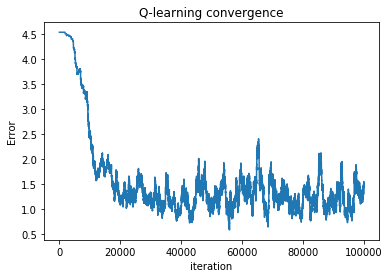

In [8]:
# ---------------------------
# Convergence of Q-Learning
# ---------------------------

# Number of Q learning iterations
n_steps = int(1e5)  
#n_steps = 10

# Get optimal value function and its greedy policy
Q0 = np.zeros((env.Ns, env.Na))
Q_opt, pi_opt = value_iteration(Q0, env, epsilon=1e-6)

# Create qlearning object
qlearning = QLearning(env, gamma=env.gamma)

# Iterate
tt = 0
Q_est = np.zeros((n_steps, env.Ns, env.Na))
while tt < n_steps:
    qlearning.step()
    # Store estimate of Q*
    Q_est[tt, :, :] = qlearning.Q
    tt +=1
    

# Compute greedy policy (with estimated Q)
greedy_policy = np.argmax(qlearning.Q, axis=1)

# Plot
diff = np.abs(Q_est - Q_opt).mean(axis=(1,2))
plt.plot(diff)
plt.xlabel('iteration')
plt.ylabel('Error')
plt.title("Q-learning convergence")

print(env.render())
print("optimal policy: ", pi_opt)
print("est policy:", greedy_policy)

for state in env.states:
    print(state)
    print("true: ", Q_opt[state, :])
    print("est: ", Q_est[-1,state, :])
    print("----------------------------")




# Exercise 4: SARSA

Implement SARSA and test its convergence.

In [9]:
#-------------------------------
# SARSA implementation
# ------------------------------

class Sarsa:
    """
    Implements SARSA algorithm.

    If learning_rate is None; alpha(x,a) = 1/max(1, N(s,a))**alpha
    """
    def __init__(self, env, gamma, alpha=0.8, learning_rate=None, min_learning_rate=0.01, tau=1.0, tau_decay=0.9995,
                 tau_min=0.1, seed=42):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.min_learning_rate = min_learning_rate
        self.tau = tau
        self.tau_decay = tau_decay
        self.tau_min = tau_min
        self.Q = np.zeros((env.Ns, env.Na))
        self.Nsa = np.zeros((env.Ns, env.Na))
        self.state = env.reset()
        self.RS = np.random.RandomState(seed)

    def get_delta(self, r, x, a, y, next_a, done):
        """
        :param r: reward
        :param x: current state
        :param a: current action
        :param y: next state
        :return:
        """
        q_y_a = self.Q[y, next_a]
        q_x_a = self.Q[x, a]

        return r + self.gamma*q_y_a - q_x_a

    def get_learning_rate(self, s, a):
        if self.learning_rate is None:
            return max(1.0/max(1.0, self.Nsa[s, a])**self.alpha, self.min_learning_rate)
        else:
            return max(self.learning_rate, self.min_learning_rate)

    def get_action(self, state):
        q = self.Q[state, :]
        prob = softmax(q/self.tau)
        a = np.random.choice(self.env.actions, p=prob)
        return a

    def step(self):
        # Current state
        x = self.env.state

        # Choose action
        a = self.get_action(x)

        # Learning rate
        alpha = self.get_learning_rate(x, a)

        # Take step
        observation, reward, done, info = self.env.step(a)
        y = observation
        r = reward
        next_a = self.get_action(y)
        delta = self.get_delta(r, x, a, y, next_a, done)

        # Update
        self.Q[x, a] = self.Q[x, a] + alpha*delta

        self.Nsa[x, a] += 1

        if done:
            # print(x, observation, reward)
            self.tau = max(self.tau*self.tau_decay, self.tau_min)
            self.env.reset()

(S: starting point, safe) (F: frozen surface, safe) (H: hole, fall to your doom) (G: goal, where the frisbee is located)
SFFF
FHFH
FFFH
HFFG
Current state 2
None
optimal policy:  [0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]
est policy: [0 3 0 3 0 0 2 0 3 1 0 0 0 1 2 0]
0
true:  [3.60941723 3.44655723 3.44655723 3.26608565]
est:  [1.24380036 1.2200373  1.22706206 0.60478605]
----------------------------
1
true:  [2.12310376 2.11500048 1.95214047 3.09512236]
est:  [0.23469874 0.41958533 0.23795037 1.13475526]
----------------------------
2
true:  [3.06953292 2.93698449 2.9288812  2.79161063]
est:  [1.21332779 0.41455334 0.56356686 0.08584844]
----------------------------
3
true:  [1.81148875 1.81148875 1.67894031 2.65095891]
est:  [0.12433847 0.10210099 0.02752937 0.15095817]
----------------------------
4
true:  [4.17932748 3.0363456  2.85587402 2.46643535]
est:  [1.47227564 0.76084765 0.35407898 0.09163911]
----------------------------
5
true:  [0. 0. 0. 0.]
est:  [0. 0. 0. 0.]
------------------

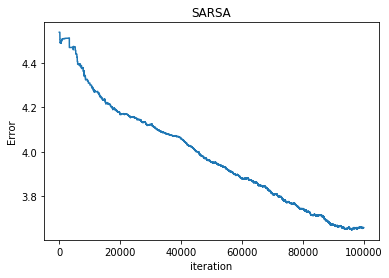

In [10]:
# ---------------------------
# Convergence of SARSA
# ---------------------------

# Create SARSA object
sarsa = Sarsa(env, gamma=env.gamma)

# Iterate
tt = 0
Q_est = np.zeros((n_steps, env.Ns, env.Na))
while tt < n_steps:
    sarsa.step()
    # Store estimate of Q*
    Q_est[tt, :, :] = sarsa.Q
    tt +=1

# Compute greedy policy (with estimated Q)
greedy_policy = np.argmax(sarsa.Q, axis=1)

# Plot
diff = np.abs(Q_est - Q_opt).mean(axis=(1,2))
plt.plot(diff)
plt.xlabel('iteration')
plt.ylabel('Error')
plt.title("SARSA")


print(env.render())
print("optimal policy: ", pi_opt)
print("est policy:", greedy_policy)

for state in env.states:
    print(state)
    print("true: ", Q_opt[state, :])
    print("est: ", Q_est[-1,state, :])
    print("----------------------------")